# SOM Tutorial

**NOTE:** This tutorial uses supplemental data that can be obtained from [cirada.ca](cirada.ca). It can be unpacked any run from any directory, and contains another copy of this same notebook.

In this tutorial we will demonstrate the process of training and analyzing a SOM. As an example we will follow the process used to quantify the probability that a component in the VLASS Component Catalogue is a false positive originating from a sidelobe.

The process is divided into these steps:
1. Create the sample
1. Preprocess the images
1. Train the SOM
1. Inspect the SOM
1. Map a sample onto the SOM
1. Annotate the SOM
1. Update the catalogue

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pyink as pu

# 1. Creating the sample

For this exercise we have provided a 10,000 row subset of the catalogue used for the actual analysis. This is done to reduce download sizes and save processing time. The full catalogue (the VLASS Component Catalogue) is available at [cirada.ca](cirada.ca), and the subset is `catalogue.csv`.

The initial training sample was selected to include only components with a `Quality_flag` of either 0 or 1 and a `Peak_to_ring` < 3. For the main analysis we trained the SOM on a sample of 100,000 radio components

    sample = pd.read_csv(cirada_catalogue)
    sample = sample[sample.Quality_flag.isin([0,1])]
    sample = sample["Peak_to_ring"] < 3
    sample = sample.sample(100000)  # choose 100k components at random
    sample = sample.reset_index(drop=True)  # Reset the DataFrame indexing.

In [2]:
sample = pd.read_csv("catalogue.csv")
sample

,Component_name,Component_id,Isl_id,RA,DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,Maj,...,Quality_flag,QL_cutout,NN_dist,Source_name,Source_type,BMAJ,BMIN,BPA,SNR,filename
0,VLASS1QLCIR J004257.79+304313.0,29,27,10.740822,30.720281,32.468187,1.023215,19.851679,0.171706,5.230621,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,11.236506,NaN,N/,3.290233,2.198598,87.322411,189.091305,J004257.79+304313.0_VLASS.fits
1,VLASS1QLCIR J022923.70-295915.7,30,46,37.348782,-29.987707,1.363831,0.255306,1.090526,0.125906,2.879801,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,22.110705,NaN,N/,2.914843,1.832025,41.237228,11.250388,J022923.70-295915.7_VLASS.fits
2,VLASS1QLCIR J015858.84-103430.7,18,24,29.745193,-10.575197,1.956885,0.372287,1.356359,0.162130,4.311354,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,8.514558,NaN,N/,3.420774,2.163553,19.322481,12.209361,J015858.84-103430.7_VLASS.fits
3,VLASS1QLCIR J083146.46+321921.1,22,22,127.943613,32.322531,2.765610,0.301314,2.325089,0.152999,3.179914,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,3.640656,NaN,N/,2.721744,2.334467,70.273323,18.478435,J083146.46+321921.1_VLASS.fits
4,VLASS1QLCIR J003806.90+094836.3,38,57,9.528788,9.810094,1.467254,0.285732,1.162339,0.139291,2.984821,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,414.425884,NaN,N/,2.521315,2.072352,-30.685944,10.870085,J003806.90+094836.3_VLASS.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,VLASS1QLCIR J075055.32+113453.9,26,38,117.730532,11.581647,3.191120,0.438942,1.402818,0.140143,5.002572,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,6.632904,NaN,N/,3.669662,2.185410,-57.001343,24.332950,J075055.32+113453.9_VLASS.fits
9996,VLASS1QLCIR J050453.37-295106.6,38,123,76.222411,-29.851844,2.232533,0.490084,1.273297,0.190691,3.396734,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,91.955294,J050453.37-295106.6,SC,3.000371,1.866237,65.633324,12.651074,J050453.37-295106.6_VLASS.fits
9997,VLASS1QLCIR J041040.46-212553.6,37,61,62.668613,-21.431578,3.377112,0.362538,1.844038,0.134732,3.757919,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,6.344397,NaN,N/,2.824223,1.674675,53.150322,26.166925,J041040.46-212553.6_VLASS.fits
9998,VLASS1QLCIR J101952.35+234415.4,69,80,154.968130,23.737631,2.517101,0.340048,1.742439,0.149760,4.178187,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,6.206152,J101952.50+234415.8,CD,3.491718,2.256733,-64.431549,17.385553,J101952.35+234415.4_VLASS.fits


# 2. Preprocess the images

Before preprocessing the images (which creates an Image Binary), first make sure that there is an image cutout for each component in the catalogue. These are already provided in the `cutouts` directory.

The steps involved in preprocessing the images will depend on the science at hand. The only common requirement is that all images are normalized onto the same scale (generally 0 to 1) so that the SOM training is well-behaved.

In [3]:
import os
from tqdm import tqdm
from astropy.io import fits
from astropy.wcs import WCS

def load_fits(filename, ext=0):
    hdulist = fits.open(filename)
    d = hdulist[ext]
    return d


def load_radio_fits(filename, ext=0):
    """Load the data from a single extension of a fits file."""
    hdu = load_fits(filename, ext=ext)
    wcs = WCS(hdu.header).celestial
    hdu.data = np.squeeze(hdu.data)
    hdu.header = wcs.to_header()
    return hdu


def scale_data(data, log=False, minsnr=None):
    """Scale the data so that the SOM behaves appropriately."""
    img = np.zeros_like(data)
    noise = pu.rms_estimate(data[data != 0], mode="mad", clip_rounds=2)
    # data - np.median(remove_zeros)

    if minsnr is not None:
        mask = data >= minsnr * noise
    else:
        mask = np.ones_like(data, dtype=bool)
    data = data[mask]

    if log:
        data = np.log10(data)
    img[mask] = pu.minmax(data)
    return img.astype(np.float32)

In [4]:
def radio_preprocess(idx, sample, path="images", img_size=(150, 150), **kwargs):
    """Preprocess a VLASS image.
    """
    try:
        radio_comp = sample.iloc[idx]
        radio_file = radio_comp["filename"]
        radio_file = os.path.join(path, radio_file)
        radio_hdu = load_radio_fits(radio_file)
        radio_data = radio_hdu.data
        return idx, scale_data(radio_data, **kwargs)
    
    except Exception as e:
        print(f"Failed on index {idx}: {e}")
        return None


def run_prepro_seq(sample, outfile, shape=(150, 150), **kwargs):
    """Non-parallelized preprocessing for all VLASS images.
    """
    with pu.ImageWriter(outfile, 0, shape, clobber=True) as pk_img:
        for idx in tqdm(sample.index):
            out = radio_preprocess(idx, sample, img_size=shape, **kwargs)
            if out is not None:
                pk_img.add(out[1], attributes=out[0])

In order to preprocess the image cutouts for the sidelobe analysis, we adopt a simple algorithm.
1. Estimate the rms in an image cutout
1. Mask out all values below a signal-to-noise ratio of 2
1. Apply a log scaling to the remaining data
1. Scale the data on a 0 to 1 scale

Each image is processed sequentially after the creation of an `pu.ImageWriter` object.

In addition, the index of the catalogue entry is recorded using the `attributes` keyword in order to track any images that have failed the preprocessing step. This occurs for one image in this sample, which we use to demonstrate how to handle missing entries.

The output image binary contains 9999 entries, which is a different size from the original catalogue. The `IMG_catalogue.bin.records.pkl` file is (automatically) used to keep track of the differences.

In [5]:
imbin_file = "IMG_catalogue.bin"
run_prepro_seq(sample, imbin_file, shape=(150, 150), path="cutouts", log=True, minsnr=2)

 62%|██████▏   | 6220/10000 [00:37<00:22, 164.54it/s]/home/adrian/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adrian/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/adrian/Projects/pyink/pyink/preprocessing.py:76: RuntimeWarning: invalid value encountered in true_divide
  p = np.polyfit(binc[mask], np.log10(counts[mask] / np.max(counts)), 2)
 63%|██████▎   | 6254/10000 [00:37<00:22, 164.75it/s]

Failed on index 6235: zero-size array to reduction operation fmin which has no identity


100%|██████████| 10000/10000 [00:59<00:00, 167.71it/s]


# 3. Train the SOM

The SOM training was performed using the `train_som.sh` script on the main sample of 100,000 components. The resulting SOM is provided here as training on the smaller sample will provide poorer results.

A single training stage is run as follows

    Pink --train $IMG $OUT3 --init $OUT2 --numthreads 10 \
     --som-width $WIDTH --som-height $HEIGHT --num-iter 10 \
         --dist-func unitygaussian 0.7 0.05 \
         --inter-store keep -p 10 -n 360 \
         --euclidean-distance-shape circular

The parameters involved are as follows:
* \$IMG: The Image Binary
* \$OUT2: The output SOM file from the previous training stage.
* \$OUT3: The output SOM file for the current training stage.
* \$HEIGHT: An integer corresponding to the height of the SOM.
* \$WIDTH: An integer corresponding to the width of the SOM.
* --dist-func unitygaussian: The distribution function is a gaussian whose amplitude is normalized to 1. The two following numbers are the dispersion (sigma) of the gaussian function and then the damping factor, which reduces the magnitude to the update to neurons that are distant from the best-matching neuron.
* --euclidean-distance-shape circular: A circular aperture is imposed when computing the Euclidean distance in order to prevent large differences caused by bright components near the image edge being rotated out of the frame.
* -n 360: The number of rotations. With n=360 each will be 1 degree.
* -num-iter 10: The dataset will be iterated through 10 times during training.

# 4. Inspect the SOM

Once a SOM has been trained, the first step is to visually assess the neurons to qualitatively determine whether the training has been successful. This visual inspection is best for spotting large errors in the training process. One should look for the morphologies being identified by the SOM, ensuring they are indicative of the structures of interest in the training sample.

Here we show the methods in `pyink` that are helpful when plotting the SOM or one of its neurons. In addition, `som.explore` can be used with the interactive matplotlib interface from the command line in order to step through the neurons one by one, with all channels plotted together.

In [6]:
som = pu.SOM("SOM_B3_h10_w10_vlass.bin")

print(som.som_rank)
print(som.som_shape)
print(som.neuron_rank)
print(som.neuron_shape)
print(som.neuron_size)

2
(10, 10, 1)
2
(1, 213, 213)
45369


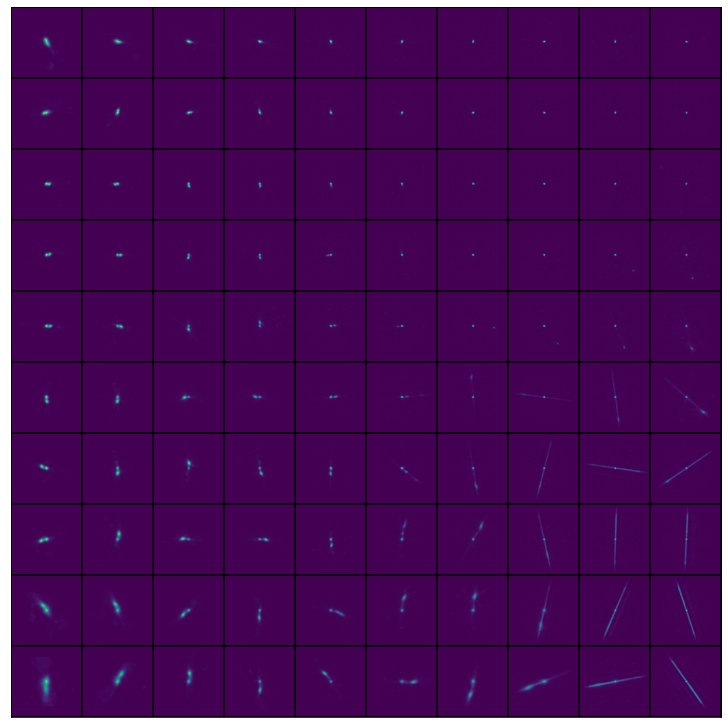

In [7]:
# This SOM contains only one channel, but when multiple are present
# the user should select one at a time.
som.plot(channel=0)

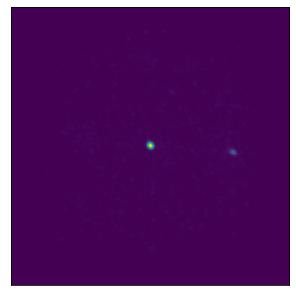

In [8]:
neuron = (4,6)
som.plot_neuron(neuron)
# Equivalent to
# plt.imshow(som[neuron][0])
# The `0` corresponds to the channel of interest.

# som.explore() can also be used to navigate the SOM,
# but this works best in the matplotlib interactive window.

# 5. Map a sample onto the SOM

A quantitative exploration of the SOM requires that a sample be mapped onto it. During the inspection stage this should be the training sample, while the final results are obtained by mapping the entire catalogue onto the SOM.

A sample can be mapped onto the SOM as follows. This is provided as the final step in `train_som.sh`.

    Pink --map IMG_catalogue.bin MAP_catalogue.bin SOM_B3_h10_w10_vlass.bin \
        --numthreads 8 --som-width 10 --som-height 10 \
        --store-rot-flip TRANSFORM_catalogue.bin \
        --euclidean-distance-shape circular -n 360 | tee mapping_step.log

* MAP_catalogue.bin: The output MAP binary file.
* TRANSFORM_catalogue.bin: The output TRANSFORM binary file.

In [9]:
import subprocess

def map_imbin(imbin_file, som_file, map_file, trans_file, 
              som_width, som_height, numthreads=8, cpu=False, nrot=360, log=True):
    """Map an image binary onto a SOM using Pink."""
    commands = [
        "Pink",
        "--map",
        imbin_file,
        map_file,
        som_file,
        "--numthreads",
        f"{numthreads}",
        "--som-width",
        f"{som_width}",
        "--som-height",
        f"{som_height}",
        "--store-rot-flip",
        trans_file,
        "--euclidean-distance-shape",
        "circular",
        "-n",
        str(nrot),
    ]
    if cpu:
        commands += ["--cuda-off"]

    if log:
        map_logfile = map_file.replace(".bin", ".log")
        with open(map_logfile, "w") as log:
            subprocess.run(commands, stdout=log)
    else:
        subprocess.run(commands)

map_imbin("IMG_catalogue.bin", "SOM_B3_h10_w10_vlass.bin", 
          "MAP_catalogue.bin", "TRANSFORM_catalogue.bin", 
          10, 10, numthreads=8, cpu=False, log=True)

In order to explore the mapped dataset, one should load:
* The catalogue
* The image binary
* A SOMSet containing the SOM, Map, and Transform binaries

As mentioned previously, the catalogue and image binary are not the same size as one image failed during preprocessing. Provided the `IMG_catalogue.bin.records.pkl` file is in the same dirctory as the main image binary, the `records` property of the image binary will be created. This allows us to trim the initial catalogue used the indices of the images that were preprocessed successfully. 

In [10]:
# Need to exclude the failed preprocessing entries from the sample.
imgs = pu.ImageReader("IMG_catalogue.bin")
print(imgs.data.shape)
sample = sample.iloc[imgs.records].reset_index()
sample

(9999, 1, 150, 150)


,index,Component_name,Component_id,Isl_id,RA,DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...,Quality_flag,QL_cutout,NN_dist,Source_name,Source_type,BMAJ,BMIN,BPA,SNR,filename
0,0,VLASS1QLCIR J004257.79+304313.0,29,27,10.740822,30.720281,32.468187,1.023215,19.851679,0.171706,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,11.236506,NaN,N/,3.290233,2.198598,87.322411,189.091305,J004257.79+304313.0_VLASS.fits
1,1,VLASS1QLCIR J022923.70-295915.7,30,46,37.348782,-29.987707,1.363831,0.255306,1.090526,0.125906,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,22.110705,NaN,N/,2.914843,1.832025,41.237228,11.250388,J022923.70-295915.7_VLASS.fits
2,2,VLASS1QLCIR J015858.84-103430.7,18,24,29.745193,-10.575197,1.956885,0.372287,1.356359,0.162130,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,8.514558,NaN,N/,3.420774,2.163553,19.322481,12.209361,J015858.84-103430.7_VLASS.fits
3,3,VLASS1QLCIR J083146.46+321921.1,22,22,127.943613,32.322531,2.765610,0.301314,2.325089,0.152999,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,3.640656,NaN,N/,2.721744,2.334467,70.273323,18.478435,J083146.46+321921.1_VLASS.fits
4,4,VLASS1QLCIR J003806.90+094836.3,38,57,9.528788,9.810094,1.467254,0.285732,1.162339,0.139291,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,414.425884,NaN,N/,2.521315,2.072352,-30.685944,10.870085,J003806.90+094836.3_VLASS.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9995,VLASS1QLCIR J075055.32+113453.9,26,38,117.730532,11.581647,3.191120,0.438942,1.402818,0.140143,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,6.632904,NaN,N/,3.669662,2.185410,-57.001343,24.332950,J075055.32+113453.9_VLASS.fits
9995,9996,VLASS1QLCIR J050453.37-295106.6,38,123,76.222411,-29.851844,2.232533,0.490084,1.273297,0.190691,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,91.955294,J050453.37-295106.6,SC,3.000371,1.866237,65.633324,12.651074,J050453.37-295106.6_VLASS.fits
9996,9997,VLASS1QLCIR J041040.46-212553.6,37,61,62.668613,-21.431578,3.377112,0.362538,1.844038,0.134732,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,6.344397,NaN,N/,2.824223,1.674675,53.150322,26.166925,J041040.46-212553.6_VLASS.fits
9997,9998,VLASS1QLCIR J101952.35+234415.4,69,80,154.968130,23.737631,2.517101,0.340048,1.742439,0.149760,...,0.0,http://legacysurvey.org/viewer/cutout.fits?ra=...,6.206152,J101952.50+234415.8,CD,3.491718,2.256733,-64.431549,17.385553,J101952.35+234415.4_VLASS.fits


In [11]:
somset = pu.SOMSet(som, "MAP_catalogue.bin", "TRANSFORM_catalogue.bin")
# Note that these can be initialized either from the file name (string) or 
# from the corresponding pu.SOM/pu.Mapping/pu.Transform objects.

We now show several helpful tools for visualizing either the preprocessed images or mapping statistics.

Plotting a preprocessed image can be done using `pu.plot_image`. This will plot a random index unless the `idx` argument is specified.

For multi-channel image binaries each channel will be shown along the horizontal axis.

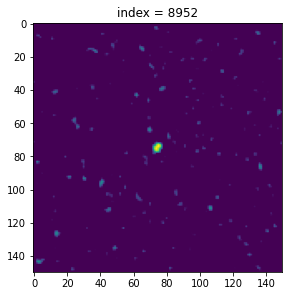

In [12]:
# Plot a random preprocessed image.
# Can select a specific index using the `idx` keyword.
pu.plot_image(imgs, idx=None)

One can also plot the best-matching neuron alongside any individual image by setting `show_bmu=True` and including a `pu.SOMSet` in the `somset` keyword. It is also recommended to set `apply_transform=True` so that the neuron will be transformed and trimmed to match the frame of the input image.

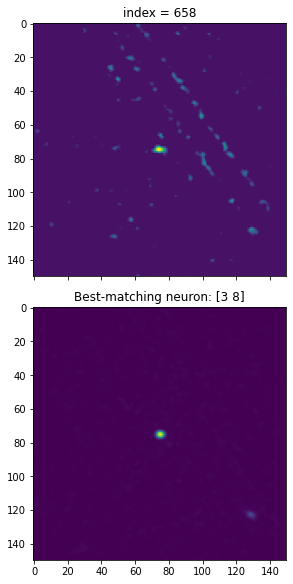

In [13]:
pu.plot_image(imgs, somset=somset, apply_transform=True, show_bmu=True)

In [14]:
# The coherence is a useful quantity to track during the training process
print(somset.mapping.coherence())

8847


In order to measure the number of matches to each neuron, use the `bmu_counts` function within the `pu.Mapping` object. This is an array with the same shape as the SOM (so normally 2 dimensions).

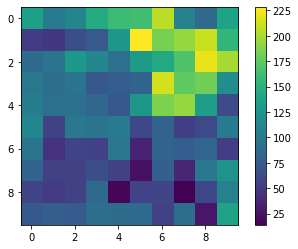

In [15]:
plt.imshow(somset.mapping.bmu_counts())
plt.colorbar()

If each entry in the catalogue is associated with a label, these can also be mapped onto the SOM. This is done using the `pu.Mapping.map_labels` function. We demonstrate this by randomly assigning labels to each entry.

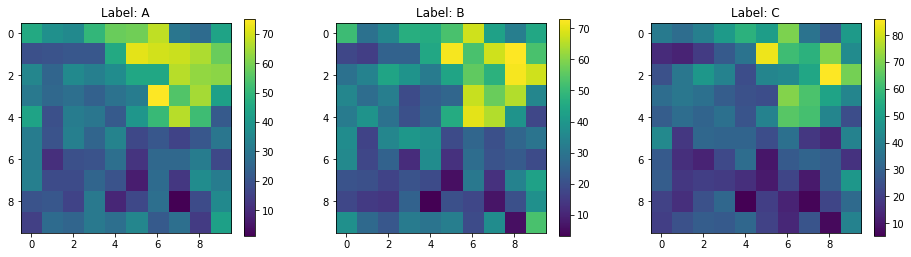

In [16]:
# Here we demonstrate how to map a series of labels onto the SOM
labels = ["A", "B", "C"]
random_labels = np.random.choice(labels, somset.mapping.data.shape[0])
label_counts = somset.mapping.map_labels(random_labels)

fig, axes = plt.subplots(1, 3, figsize=(16,4))
for key, ax in zip(label_counts, axes):
    im = ax.imshow(label_counts[key])
    ax.set_title(f"Label: {key}")
    plt.colorbar(im, ax=ax)

# 6. Annotate the SOM

The annotation step is where ones attaches some kind of annotation -- whether it be a text label, image-based annotation, etc. -- to each neuron. A text-based annotation can be kept track of in a text file or spreadsheet while examining each neuron using `pu.SOM.explore` or another plotting tool. A script for creating image-based annotations is provided in `pyink/Example_Scripts`.

For the project covered in this tutorial our goal was to assign a probability that a component corresponding to a given neuron is a sidelobe. There are a variety of ways to accomplish this. We have done this by plotting, for each neuron, a random sample of 100 images that have been matched to the neuron. A group of radio astronomers then counted the number of false positives for each grid.

In [17]:
from itertools import product

def grid_plot_prepro(sample: pd.DataFrame, imgs: pu.ImageReader):
    """Create a 10x10 grid of preprocessed images. See example below.

    Arguments:
        sample (pd.DataFrame): The table of 100 images to be plotted.
        imgs (pu.ImageReader): The ImageReader binary
    """
    inds = sample.index
    data = imgs.data[inds, 0]
    if len(inds) < 100:
        blank = np.zeros((100 - len(inds), 150, 150))
        data = np.vstack([data, blank])
    data = data.reshape((10, 10, 150, 150))
    data = np.moveaxis(data, 2, 1).reshape((1500, 1500))

    plt.figure(figsize=(20, 20), constrained_layout=True)
    plt.imshow(data)
    plt.xticks([])
    plt.yticks([])

    for i, j in product(range(10), range(10)):
        if j * 10 + i >= len(inds):
            continue
        plt.scatter(150 * i + 75, 150 * j + 75, marker="o", facecolors="none", edgecolors="r", s=200)

    for i in range(1, 10):
        plt.axvline(150 * i, c="w", ls="-", lw=0.5)
        plt.axhline(150 * i, c="w", ls="-", lw=0.5)

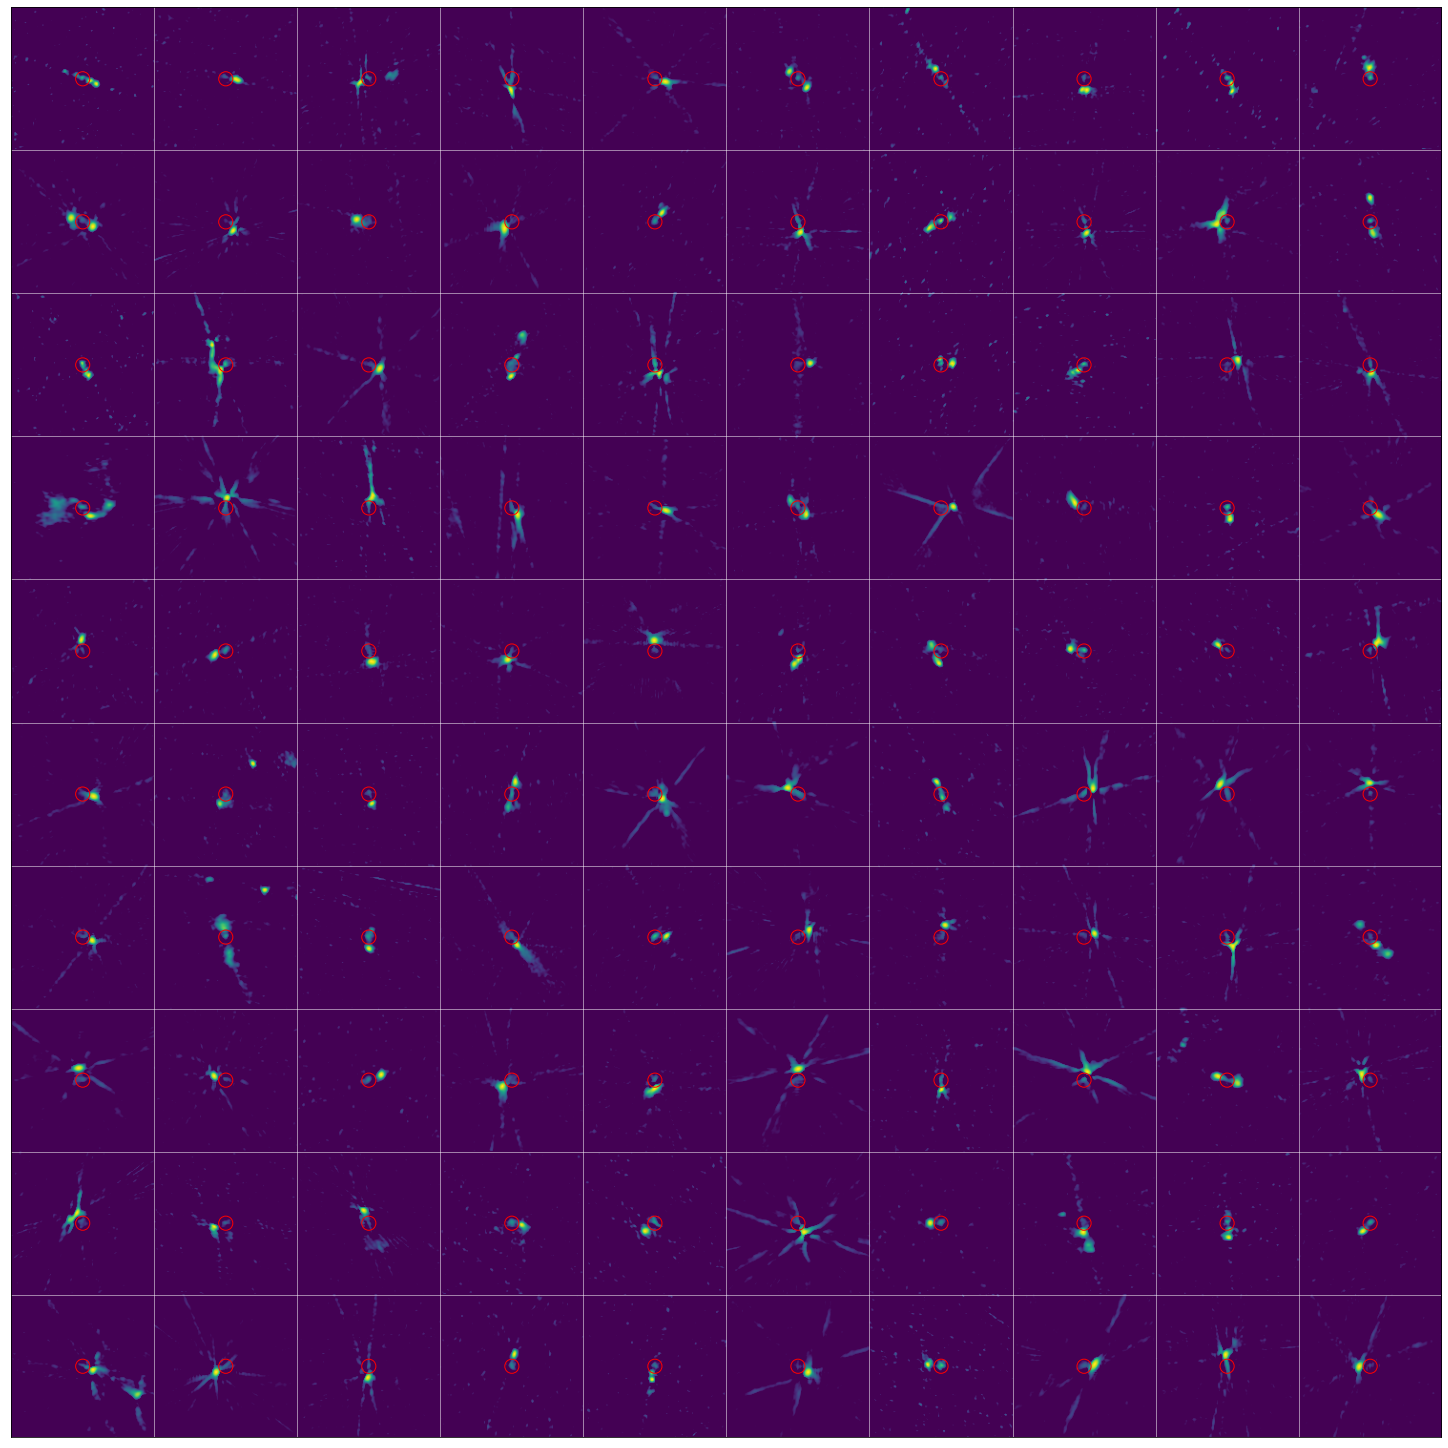

In [18]:
neuron = (5, 2)
idxs = somset.mapping.images_with_bmu(neuron)
subset = sample.iloc[idxs].sample(min(100, len(idxs)))
grid_plot_prepro(subset, imgs)

In the above neuron the consensus number of spurious components was 55/100. This refers specifically to the component indicated by the red circle. This process was performed for each neuron and the results entered into a csv file.

The annotations can then be added as new columns to the original catalogue. In this case each radio component inherits the probability that its neuron corresponds to a sidelobe, so in each of the images presented in the grid the components will have a sidelobe probability of 0.55.

More complex approaches would include
* Create labels for a sample of images, classifying each as either real or sidelobe. Map these labels onto the SOM and then measure the fraction of sidelobes that are matched to each neuron.
* Using the previous sample of classifications, train another machine learning model (likely a neural network) that takes as input the Euclidean distance to _all_ neurons for a single image and is trained to predict whether an image is real or a sidelobe.

# 7. Update the catalogue

The sidelobe probabilities that we estimated for this SOM are provided in `neuron_info.csv`. This is a csv of a neuron's row, column, and sidelobe probability. We will now show how this information can be appended onto the original catalogue.

In [19]:
# First add the best-matching neuron and Euclidean distance info to the catalogue
bmu = somset.mapping.bmu()
sample["Best_neuron_y"] = bmu[:, 0]
sample["Best_neuron_x"] = bmu[:, 1]
sample["Neuron_dist"] = somset.mapping.bmu_ed()

# Read in the table with sidelobe probabilities
neuron_table = pd.read_csv("neuron_info.csv")
# Set all values to -1 (null)
Psidelobe = -np.ones((neuron_table.bmu_y.max() + 1, neuron_table.bmu_x.max() + 1))
# Update values for each neuron using the corresponding number from the table
Psidelobe[neuron_table.bmu_y, neuron_table.bmu_x] = neuron_table.P_sidelobe

# Only components with low Peak_to_ring and S_Code != "E" should inherit P_sidelobe
sample["P_sidelobe"] = -np.ones(len(sample))
lowPtR = (sample.Peak_to_ring < 3) & (sample.S_Code != "E")
sample.loc[lowPtR, "P_sidelobe"] = 0.01 * Psidelobe[bmu[:, 0], bmu[:, 1]][lowPtR]

Since one component failed preprocessing, the catalogue does not currently match its original size. To recover the original catalogue we load it once more before merging in the new columns.

In [20]:
# First trim the table to just the new columns and a unique component identifier
# This saves on computing time and makes the join cleaner.
neuron_cols = ["Best_neuron_y", "Best_neuron_x", "Neuron_dist", "P_sidelobe"]
update_cols = sample[["Component_name"] + neuron_cols]

# Use a left join to merge the colums
original_cat = pd.read_csv("catalogue.csv")
final_cat = pd.merge(original_cat, update_cols, how="left")
final_cat

,Component_name,Component_id,Isl_id,RA,DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,Maj,...,Source_type,BMAJ,BMIN,BPA,SNR,filename,Best_neuron_y,Best_neuron_x,Neuron_dist,P_sidelobe
0,VLASS1QLCIR J004257.79+304313.0,29,27,10.740822,30.720281,32.468187,1.023215,19.851679,0.171706,5.230621,...,N/,3.290233,2.198598,87.322411,189.091305,J004257.79+304313.0_VLASS.fits,7.0,1.0,3.900831,0.06
1,VLASS1QLCIR J022923.70-295915.7,30,46,37.348782,-29.987707,1.363831,0.255306,1.090526,0.125906,2.879801,...,N/,2.914843,1.832025,41.237228,11.250388,J022923.70-295915.7_VLASS.fits,8.0,5.0,4.235639,0.22
2,VLASS1QLCIR J015858.84-103430.7,18,24,29.745193,-10.575197,1.956885,0.372287,1.356359,0.162130,4.311354,...,N/,3.420774,2.163553,19.322481,12.209361,J015858.84-103430.7_VLASS.fits,8.0,3.0,4.276369,0.17
3,VLASS1QLCIR J083146.46+321921.1,22,22,127.943613,32.322531,2.765610,0.301314,2.325089,0.152999,3.179914,...,N/,2.721744,2.334467,70.273323,18.478435,J083146.46+321921.1_VLASS.fits,2.0,3.0,1.907959,0.01
4,VLASS1QLCIR J003806.90+094836.3,38,57,9.528788,9.810094,1.467254,0.285732,1.162339,0.139291,2.984821,...,N/,2.521315,2.072352,-30.685944,10.870085,J003806.90+094836.3_VLASS.fits,3.0,7.0,2.241574,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,VLASS1QLCIR J075055.32+113453.9,26,38,117.730532,11.581647,3.191120,0.438942,1.402818,0.140143,5.002572,...,N/,3.669662,2.185410,-57.001343,24.332950,J075055.32+113453.9_VLASS.fits,4.0,1.0,3.056019,0.00
9996,VLASS1QLCIR J050453.37-295106.6,38,123,76.222411,-29.851844,2.232533,0.490084,1.273297,0.190691,3.396734,...,SC,3.000371,1.866237,65.633324,12.651074,J050453.37-295106.6_VLASS.fits,4.0,8.0,3.588012,0.01
9997,VLASS1QLCIR J041040.46-212553.6,37,61,62.668613,-21.431578,3.377112,0.362538,1.844038,0.134732,3.757919,...,N/,2.824223,1.674675,53.150322,26.166925,J041040.46-212553.6_VLASS.fits,4.0,3.0,3.074162,0.02
9998,VLASS1QLCIR J101952.35+234415.4,69,80,154.968130,23.737631,2.517101,0.340048,1.742439,0.149760,4.178187,...,CD,3.491718,2.256733,-64.431549,17.385553,J101952.35+234415.4_VLASS.fits,4.0,4.0,3.437845,0.03
